# Segment and clustering neighborhoods in Toronto (Capstone Week 3)


## Step 1: turning the wiki data into a dataframe

First, load BeautifulSoup, the wikipedia page, and obtain the rows of the relevant table

In [1]:
from bs4 import BeautifulSoup
import numpy as np, pandas as pd, requests

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url)

soup = BeautifulSoup(r.text, 'html.parser')

wiki_table = soup.find(class_="wikitable")

wiki_rows = wiki_table.find_all("tr")


Now define an empty pandas dataframe to contain the elements, and loop through each row of the BeautifulSoup extract, mapping each cell to postcode/borough/neighborhood based on table position.  Discard rows where borough is not assigned, use borough if neighborhood is not assigned, 
and create dictionaries of boroughs (brs) and neighborhoods (nbs) for later use.

In [2]:

# define the dataframe columns
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods.set_index('PostalCode', inplace=True)

brs = {}
nbs = {}

for row in wiki_rows:
    #rint(row)
    cells = row.find_all("td")
    cell_list = [x.get_text() for x in cells]
    if len(cell_list) > 0 and cell_list[1] != 'Not assigned':
        postal_code = cell_list[0]
        borough = cell_list[1]
        neighborhood = cell_list[1] if cell_list[2].replace('\n','') == 'Not assigned' else cell_list[2].replace('\n','')
        
        brs[postal_code] = borough
        
        if postal_code in nbs:
            nbs[postal_code] = nbs[postal_code] + ", " + neighborhood
        else:
            nbs[postal_code] = neighborhood

            
for pcode in brs:
    neighborhoods = neighborhoods.append({'PostalCode': pcode,
                                         'Borough': brs[pcode],
                                         'Neighborhood': nbs[pcode]}, ignore_index=True)
    


In [3]:
print("The resulting pandas dataframe is the following size:")      
neighborhoods.shape

The resulting pandas dataframe is the following size:


(103, 3)

## Step 2: obtain geocoding per postcode

In [4]:
!conda install -c conda-forge geocoder --yes 
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library


Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - geocoder


The following NEW packages will be INSTALLED:

  geocoder           conda-forge/noarch::geocoder-1.38.1-py_0
  orderedset         conda-forge/linux-64::orderedset-2.0-py36_0
  ratelim            conda-forge/linux-64::ratelim-0.1.6-py36_0

The following packages will be UPDATED:

  ca-certificates                     2018.11.29-ha4d7672_0 --> 2019.3.9-hecc5488_0
  certifi                              2018.11.29-py36_1000 --> 2019.3.9-py36_0
  conda                                        4.6.4-py36_0 --> 4.6.9-py36_0
  openssl                              1.1.1a-h14c3975_1000 --> 1.1.1b-h14c3975_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64:

The code below tries up to three times to obtain a latitude and longitude in case the service does not respond.  I am using the ArcGIS function/website since other services were not giving useful results. (Bing returned nothing, Geonames had null responses for several postcodes, OSM wouldn't relate to postcodes and borough was too general)

In [5]:
import geocoder

lat_lng_coords = None

latitude = {}
longitude = {}

with requests.Session() as session:
    for pc, nbname in nbs.items():
        attempts = 0
        while attempts < 3:
        # loop until you get the coordinates
        #while(lat_lng_coords is None):
            g = geocoder.arcgis('{}, Toronto, Ontario'.format(pc))
            print('{}, Toronto, Ontario'.format(pc))
        
            lat_lng_coords = g.latlng
            if lat_lng_coords is None:
                attempts = attempts + 1
            else:
                attempts = 10

        if lat_lng_coords is not None:
            latitude[pc] = lat_lng_coords[0]
            longitude[pc] = lat_lng_coords[1]

neighborhoods['Latitude'] = neighborhoods['PostalCode'].map(latitude)
neighborhoods['Longitude'] = neighborhoods['PostalCode'].map(longitude)

M3A, Toronto, Ontario
M4A, Toronto, Ontario
M5A, Toronto, Ontario
M6A, Toronto, Ontario
M7A, Toronto, Ontario
M9A, Toronto, Ontario
M1B, Toronto, Ontario
M3B, Toronto, Ontario
M4B, Toronto, Ontario
M5B, Toronto, Ontario
M6B, Toronto, Ontario
M9B, Toronto, Ontario
M1C, Toronto, Ontario
M3C, Toronto, Ontario
M4C, Toronto, Ontario
M5C, Toronto, Ontario
M6C, Toronto, Ontario
M9C, Toronto, Ontario
M1E, Toronto, Ontario
M4E, Toronto, Ontario
M5E, Toronto, Ontario
M6E, Toronto, Ontario
M1G, Toronto, Ontario
M4G, Toronto, Ontario
M5G, Toronto, Ontario
M6G, Toronto, Ontario
M1H, Toronto, Ontario
M2H, Toronto, Ontario
M3H, Toronto, Ontario
M4H, Toronto, Ontario
M5H, Toronto, Ontario
M6H, Toronto, Ontario
M1J, Toronto, Ontario
M2J, Toronto, Ontario
M3J, Toronto, Ontario
M4J, Toronto, Ontario
M5J, Toronto, Ontario
M6J, Toronto, Ontario
M1K, Toronto, Ontario
M2K, Toronto, Ontario
M3K, Toronto, Ontario
M4K, Toronto, Ontario
M5K, Toronto, Ontario
M6K, Toronto, Ontario
M1L, Toronto, Ontario
M2L, Toron

## Result: Output the data frame

In [6]:
neighborhoods

,Borough,Neighborhood,PostalCode,Latitude,Longitude
0,North York,Parkwoods,M3A,43.752440,-79.329271
1,North York,Victoria Village,M4A,43.730421,-79.313320
2,Downtown Toronto,"Harbourfront, Regent Park",M5A,43.655120,-79.362640
3,North York,"Lawrence Heights, Lawrence Manor",M6A,43.723125,-79.451589
4,Queen's Park,Queen's Park,M7A,43.661102,-79.391035
5,Etobicoke,Islington Avenue,M9A,43.662242,-79.528379
6,Scarborough,"Rouge, Malvern",M1B,43.811525,-79.195517
7,North York,Don Mills North,M3B,43.749195,-79.361905
8,East York,"Woodbine Gardens, Parkview Hill",M4B,43.707535,-79.311773
9,Downtown Toronto,"Ryerson, Garden District",M5B,43.657363,-79.378180


### Map the results as a sense check

In [7]:
centre_latitude = 43.655115
centre_longitude = -79.380219

centres_map = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=11) 

# add the postcode centres as red circle markers
for lat, lng, label in zip(neighborhoods.Latitude, neighborhoods.Longitude, neighborhoods.PostalCode):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(centres_map)

# display map
centres_map

## Step 3: explore and cluster neighborhoods

Setup Foursquare and helper functions

In [8]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [ ]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

geolocator = Nominatim(user_agent="foursquare_agent")

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Get top 50 nearby venues for each of the Toronto postal codes

In [10]:
LIMIT = 50

toronto_venues = getNearbyVenues(names=neighborhoods['PostalCode'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

M3A
M4A
M5A
M6A
M7A
M9A
M1B
M3B
M4B
M5B
M6B
M9B
M1C
M3C
M4C
M5C
M6C
M9C
M1E
M4E
M5E
M6E
M1G
M4G
M5G
M6G
M1H
M2H
M3H
M4H
M5H
M6H
M1J
M2J
M3J
M4J
M5J
M6J
M1K
M2K
M3K
M4K
M5K
M6K
M1L
M2L
M3L
M4L
M5L
M6L
M9L
M1M
M2M
M3M
M4M
M5M
M6M
M9M
M1N
M2N
M3N
M4N
M5N
M6N
M9N
M1P
M2P
M4P
M5P
M6P
M9P
M1R
M2R
M4R
M5R
M6R
M7R
M9R
M1S
M4S
M5S
M6S
M1T
M4T
M5T
M1V
M4V
M5V
M8V
M9V
M1W
M4W
M5W
M8W
M9W
M1X
M4X
M5X
M8X
M4Y
M7Y
M8Y
M8Z


One hot encode the venue categories for each venue and set the mean level of that category occuring for each postal code, then fill out the 1st to 10th most popular types of venues for each

In [11]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add postcode column back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move postcode column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# find mean of occurence frequency
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postalcodes_venues_sorted = pd.DataFrame(columns=columns)
postalcodes_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    postalcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)


Cluster the postcodes into 5 clusters using the venue categories - note that for some postal codes there was no category data and so a cluster was not assigned.  These postcodes have been dropped to allow the map to only display valid clusters

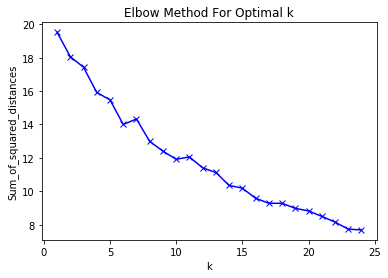

In [14]:
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped.drop('PostalCode', 1))
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The variety of categories in the data means that there is not an obvious choice for selecting a k value using the elbow method.  10 has been selected here are as a reasonable compromise but it may be helpful to either look at alternative selection methods, or to pre-group the categories to a higher level of aggregation so that similar categories are together (Lakes and Parks for instance).

In [24]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
postalcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(postalcodes_venues_sorted.set_index('PostalCode'), on='PostalCode')

In some cases no data has been returned for categories, so these rows are currently dropped from the dataset

In [25]:
toronto_merged.dropna(subset=['Cluster Labels'],inplace=True)
toronto_merged.shape

(102, 16)

The following outputs allow review of the venue types in each cluster so that the labels can be manually assigned.

In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,"Maryvale, Wexford",0.0,Convenience Store,Auto Garage,Dumpling Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market


In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Woodbine Gardens, Parkview Hill",1.0,Fast Food Restaurant,Pizza Place,Breakfast Spot,Athletics & Sports,Rock Climbing Spot,Bank,Pub,Intersection,Gastropub,Café
10,Glencairn,1.0,Pizza Place,Fast Food Restaurant,Mediterranean Restaurant,Latin American Restaurant,Japanese Restaurant,Sushi Restaurant,Asian Restaurant,Grocery Store,Ethiopian Restaurant,Event Space
11,"Cloverdale, Islington, Martin Grove, Princess ...",1.0,Pizza Place,Chinese Restaurant,Sandwich Place,Tea Room,Bank,Field,Fast Food Restaurant,Farmers Market,Fish & Chips Shop,Falafel Restaurant
51,"Cliffcrest, Cliffside, Scarborough Village West",1.0,Fast Food Restaurant,Pharmacy,Furniture / Home Store,Burger Joint,Pizza Place,Sandwich Place,Discount Store,Coffee Shop,Liquor Store,Electronics Store
60,Downsview Northwest,1.0,Fast Food Restaurant,Shopping Mall,Vietnamese Restaurant,Pizza Place,Grocery Store,Sandwich Place,Beer Store,Discount Store,Fried Chicken Joint,Coffee Shop
64,Weston,1.0,Pizza Place,Diner,Fried Chicken Joint,Convenience Store,Pharmacy,Creperie,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Field
70,Westmount,1.0,Pizza Place,Chinese Restaurant,Middle Eastern Restaurant,Sandwich Place,Coffee Shop,Intersection,Event Space,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
77,"Kingsview Village, Martin Grove Gardens, Richv...",1.0,Pizza Place,Arts & Crafts Store,Yoga Studio,Dumpling Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
82,"Clarks Corners, Sullivan, Tam O'Shanter",1.0,Pizza Place,Chinese Restaurant,Golf Course,Pharmacy,Hobby Shop,Shopping Mall,Thai Restaurant,Fried Chicken Joint,Coffee Shop,Dumpling Restaurant
89,"Albion Gardens, Beaumond Heights, Humbergate, ...",1.0,Grocery Store,Fried Chicken Joint,Pharmacy,Fast Food Restaurant,Hardware Store,Park,Video Store,Pizza Place,Beer Store,Sandwich Place


In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"Silver Hills, York Mills",2.0,Music Venue,Yoga Studio,Food Court,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm


In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,"Bathurst Manor, Downsview North, Wilson Heights",3.0,Men's Store,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm


In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Highland Creek, Rouge Hill, Port Union",4.0,Construction & Landscaping,Bar,Eastern European Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market


In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Harbourfront, Regent Park",5.0,Coffee Shop,Breakfast Spot,Spa,Food Truck,Mexican Restaurant,Event Space,Electronics Store,Restaurant,Pub,Italian Restaurant
3,"Lawrence Heights, Lawrence Manor",5.0,Clothing Store,Furniture / Home Store,American Restaurant,Cosmetics Shop,Dessert Shop,Shopping Mall,Men's Store,Electronics Store,Toy / Game Store,Chocolate Shop
4,Queen's Park,5.0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Bubble Tea Shop,College Auditorium,Burrito Place,Salad Place,Mediterranean Restaurant,Falafel Restaurant
9,"Ryerson, Garden District",5.0,Café,Middle Eastern Restaurant,Coffee Shop,Clothing Store,Ramen Restaurant,Cosmetics Shop,Theater,Food Court,Steakhouse,Beer Bar
13,"Flemingdon Park, Don Mills South",5.0,Grocery Store,Coffee Shop,Beer Store,Gym,Intersection,Yoga Studio,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
14,Woodbine Heights,5.0,Bus Line,Pharmacy,Breakfast Spot,Bar,Pub,Middle Eastern Restaurant,Fast Food Restaurant,Grocery Store,Café,Arts & Crafts Store
15,St. James Town,5.0,Coffee Shop,Restaurant,Hotel,Italian Restaurant,Gastropub,Cocktail Bar,Japanese Restaurant,Café,Gym,Beer Bar
16,Humewood-Cedarvale,5.0,Coffee Shop,Hockey Arena,Playground,Field,Park,Trail,Grocery Store,Yoga Studio,Eastern European Restaurant,Electronics Store
17,"Bloordale Gardens, Eringate, Markland Wood, Ol...",5.0,Electronics Store,Carpet Store,Fish & Chips Shop,College Rec Center,Bank,Grocery Store,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Event Space
19,The Beaches,5.0,Neighborhood,Health Food Store,Coffee Shop,Pub,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Yoga Studio


In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Lawrence Park,6.0,Bus Line,Swim School,Lake,Yoga Studio,Food Court,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant


In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,"Forest Hill North, Forest Hill West",7.0,Pharmacy,Basketball Court,Eastern European Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
85,"Agincourt North, L'Amoreaux East, Milliken, St...",7.0,Pharmacy,Sushi Restaurant,Dumpling Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm


In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Rouge, Malvern",8.0,Home Service,Pet Store,Dumpling Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
50,Humber Summit,8.0,Home Service,Hobby Shop,Auto Garage,Dumpling Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
62,Roselawn,8.0,Home Service,Food Court,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,9.0,Food & Drink Shop,Fast Food Restaurant,Park,Dumpling Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Field,Farmers Market,Farm
1,Victoria Village,9.0,Intersection,French Restaurant,Park,Grocery Store,Yoga Studio,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market
5,Islington Avenue,9.0,Pharmacy,Park,Café,Shopping Mall,Skating Rink,Grocery Store,Bank,Farmers Market,Fast Food Restaurant,Farm
7,Don Mills North,9.0,Burger Joint,Park,Bus Line,Coffee Shop,Yoga Studio,Electronics Store,Flower Shop,Fish Market,Fish & Chips Shop,Field
18,"Guildwood, Morningside, West Hill",9.0,Construction & Landscaping,Park,Gym / Fitness Center,Dry Cleaner,Fish & Chips Shop,Field,Fast Food Restaurant,Fish Market,Dumpling Restaurant,Flower Shop
21,Caledonia-Fairbanks,9.0,Park,Market,Gym,Fast Food Restaurant,Mexican Restaurant,Sporting Goods Shop,Beer Store,Bakery,Pharmacy,Women's Store
35,East Toronto,9.0,Park,Farmers Market,Italian Restaurant,Bar,Yoga Studio,Eastern European Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Field
36,"Harbourfront East, Toronto Islands, Union Station",9.0,Harbor / Marina,Music Venue,Park,Athletics & Sports,Farm,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
39,Bayview Village,9.0,Construction & Landscaping,Golf Driving Range,Park,Trail,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm
41,"The Danforth West, Riverdale",9.0,Fast Food Restaurant,Discount Store,Park,Bus Line,Grocery Store,Farm,Ethiopian Restaurant,Event Space,Falafel Restaurant,Yoga Studio


Finally, draw the map of Toronto using the 10 clusters.  The names of the cluster groups (visible when clicking on each point) have been manually assigned by reviewing the venue categories most frequently appearing for each postal code.

In [36]:
# create map
centre_latitude = 43.655115
centre_longitude = -79.380219

map_clusters = folium.Map(location=[centre_latitude, centre_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

cluster_group = ['Convenience stores', 'Fast food', 'Music venues', 'Mens stores', 'Construction', 'Coffee shops and cafes', 'Watersports', 'Pharmacies', 'Home service', 'Parks']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' (' + cluster_group[int(cluster)] + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters